# Distribution fitting Using Electric Nation DataSet

The dataset is extracted from the ElectricNation project [website](https://www.westernpower.co.uk/electric-nation-data). A copy containing the main files that we make use of are available in the subfolder [DataFiles/ElectricNation](../DataFiles/ElectricNation.zip). The project's final report is also available [here](../DataFiles/Electric_Nation_Customer_Trial_Final.pdf).


+ [Weekdays](#weekdays) (plug_in and un-plug time)
+ [Weekends](#Weekends) (plug_in and un-plug time)
+ [Consumed Energy](#consumed_energy) (During active part of charging)
+ [Charging Duration](#charging_duration)

In [1]:
# Import Modules
import numpy as np,  pandas as pd, csv, random
import matplotlib.pyplot as plt
import sys,os
import scipy.stats
import seaborn as sbn
from scipy import signal, spatial, stats

# %jupyter matplotlib
%matplotlib inline
from tqdm import tqdm

#### Define functions to use 

In [2]:
# Funtions to use later

# Define my own Kolmogorov-Smirnov test based on the one from stats toolbox
def kstest(input_data, fit_distname, params):
    """
    Perform kolmogorov-smirnov goodness of fit test 
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    fit_distname : string 
        The name of the distribution to be fitted to the input data
    params: 
       Fitted distribution list of parameters
       
    Output:
    -------
    ks: tuple 
        Statistic : float
            KS test statistic,
        pvalue :  float
            One-tailed or two-tailed p-value.

    """ 
    ksN = 50 # Sample size
    ks = stats.kstest(input_data, fit_distname, params, ksN) # 
    return ks

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def fitdistribution(input_data, dist_name, f_loc=0):
    """
    Fit the distribution given by ''dist_name'' to the rv ''input_data''
    and perform kolmogorov-smirnov goodness of fit test 
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    dist_name : string 
        The name of the distribution to be fitted to the input data
    f_loc: float, default=0 
       Location parameter for the fitted distribution
       
    Output:
    -------
    result : tuple 
        dist.name : string
            Fitted distribution name
        pvalue :  float
            Resulting from the ks fit test.
        fitting_params: list
            Fitted distribution list of parameters
            
    """ 
    
    dist = getattr(stats, dist_name) 
    fitting_params = dist.fit(input_data,)
    ks = kstest(input_data, dist.name, fitting_params )
    result = (dist.name, ks[1], *fitting_params)
    return result

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def list_fitdistribution(input_data, dist_list):
    """
    Fit all the distribution in dist_list to the input data.
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    dist_list : list of string 
        List of the name of the distribution to be fitted to the input data
       
    Output:
    -------
    fit_res_list : list of tuple 
        Each tuple is the otput of the function fitdistribution(args)
    """ 

    fit_res_list = []
    for cur_dist in tqdm(dist_list): 
        try:
            # ignore invalide and divide error
            with np.errstate(divide='ignore', invalid='ignore'):
                fit_res_list.append( fitdistribution(input_data, cur_dist) );
                
        except (ValueError, RuntimeError): 
            print('Defaulting Distribution : '+cur_dist);
            
    return fit_res_list

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def ordered_dis_df(res_list): 
    # Ordered_distribution dataframe
    """ 
    Convert the fitted list  "res_list " of tuples to dataframe and sort 
    in ascending order of p-values
    
    Inputs:
    -------
    res_list:  list 
        list containing all the fitted distribution with their parameters. 
        Output of the function list_fitdistribution(args)
    

    Output:
    -------
    res_df: dataframe
        Sorted Dataframe by p-value
        
        
    """    
    
    
    nb_params = np.shape(pd.DataFrame(res_list))[1] - 2 # Get total number of parameters defined in res - 2 (distribution name, p-value)
    params_list = ['param'+str(i) for i in range(nb_params)]# Create a list of all the parameters except the first two

    res_df = pd.DataFrame(res_list, columns=["distribution", "KS p-value", *params_list]) # Create a dataframe with the res_list_data
    res_df.sort_values(by=["KS p-value"], inplace=True, ascending=False) # sort the resulting dataframe using the p-value 
#     res_df.reset_index(inplace=True) # Reset df index i.e. add new index to df 
#     res_df.drop("index", axis=1, inplace=True) # remove the previous index used for ordering
    
    return res_df

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def plot_FittedDist (axx, dist_res_df, xx_label, nb_rows = 1, ):
    """
    Plot input data distribution and all the fitted distribution in 
    
    Inputs:
    -------
    axx:  pyplot object
        Figure, axx  handle
    dist_res_df : dataframe 
        Ordered dataframe of distribution fitted to the data and their parameters
    nb_rows: int default= 1
        Numbers of fitted distribution to plot 

    """    
    
    # define the number of rows to plot
    legend_name = []
    legend_name.append("Data")
    for rows in range(nb_rows):
        dist = getattr(stats, dist_res_df.iloc[rows,0])
        rer = 0.002
        params = [p for p in dist_res_df.iloc[rows,2:] if ~np.isnan(p)]
        xx = np.linspace(dist(*params).ppf(rer), 
                         dist(*params).ppf(1-rer),
                         1000 )
        plt.plot(xx, dist(*params).pdf(xx),)

        legend_name.append(dist_res_df.distribution[rows])

    axx.set(xlim=(0,1444),
            xticks = np.arange(0,1440,120), 
            xticklabels=range(0,24,2), 
            xlabel = xx_label )    
    plt.legend(legend_name);
    



#### Define a list of distribution

In [3]:
distribution_list = ['expon', 'gamma', 'genextreme', 'logistic', 'lognorm', 'triang', 'uniform', 'fatiguelife',
                     'gengamma', 'gennorm', 'dweibull', 'dgamma', 'gumbel_r', 'weibull_max', 'weibull_min', 'laplace', 
                     'genexpon', 'betaprime', 'fisk', 'genpareto', 'genlogistic','halfnorm', 'halflogistic', 'invgauss',
                     'invgamma', 'levy', 'loggamma', 'mielke', 'ncx2', 'ncf', 'johnsonsb', 'pareto', 'lomax', 'semicircular',
                     'rice', 'invweibull', 'foldnorm', 'foldcauchy', 'exponpow', 'exponweib', 'wald', 'wrapcauchy', 'truncexpon', 
                     'truncnorm', 't', 'rdist','beta']


#### Define location and name of file to use

In [4]:
# Define location and name of file to use
# folder = "~/Downloads/ElectricNation/"
folder = "../DataFiles/ElectricNation/" # The ElectricNation folder in ../DataFiles has been compress for space convenience.
                                        # Make sure to decompress it before calling it within the script.   
file_CrowdCharge = "CrowdCharge_Transactions.xlsx"
file_GreenFlux = "GreenFlux_Transactions.xlsx"

# Combine folder and filename
Fname_CrowdCharge = folder+file_CrowdCharge
Fname_GreenFlux = folder+file_GreenFlux

# Read only important column for our usage
ColsName = ['ChargerID','ParticipantID','StartTime', 'StopTime', 'WeekdayOrWeekend', 
            'ChargingDuration' ,'PluggedInTime', 'ConsumedkWh', 'ParticipantCarkWh' ]

# Define sheet name # Same Sheet name in both files
sheet_name = 'Transaction Data'

In [5]:
# Warning : This execution lasts 
# Import files
CrowdCharge_df = pd.read_excel(Fname_CrowdCharge, sheet_name, usecols=ColsName)
GreenFlux_df = pd.read_excel(Fname_GreenFlux, sheet_name, usecols=ColsName)

### Show Data count

In [6]:
CrowdCharge_df.count()

ChargerID            71264
ParticipantID        67365
ParticipantCarkWh    67365
StartTime            71264
StopTime             71264
PluggedInTime        71264
ConsumedkWh          71263
WeekdayOrWeekend     71264
ChargingDuration     50403
dtype: int64

### Show data head

In [7]:
CrowdCharge_df.head()

,ChargerID,ParticipantID,ParticipantCarkWh,StartTime,StopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ChargingDuration
0,35000117,EN1306,33.0,2017-05-04 19:02:00,2017-05-05 08:47:00,825,29.39,Weekday,NaN
1,35000117,EN1306,33.0,2017-05-05 17:15:00,2017-05-06 09:53:00,998,19.35,Weekday,NaN
2,35000117,EN1306,33.0,2017-05-11 16:44:00,2017-05-12 06:18:00,814,19.17,Weekday,NaN
3,35000117,EN1306,33.0,2017-05-15 18:47:00,2017-05-16 06:13:00,686,22.07,Weekday,NaN
4,35000117,EN1306,33.0,2017-05-17 15:32:00,2017-05-18 06:44:00,912,27.47,Weekday,NaN


In [8]:
GreenFlux_df.head()

,ChargerID,ParticipantID,ParticipantCarkWh,StartTime,StopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ChargingDuration
0,UK-GFX-ENA0001,EN1073,33.0,2017-01-12 15:21:00,2017-01-12 15:23:00,2,0.0,Weekday,NaN
1,UK-GFX-ENA0001,EN1073,33.0,2017-01-17 09:46:00,2017-01-17 09:51:00,5,0.2,Weekday,NaN
2,UK-GFX-ENA0009,EN1116,33.0,2017-01-24 13:51:00,2017-01-24 13:52:00,1,0.0,Weekday,NaN
3,UK-GFX-ENA0010,EN1083,33.0,2017-01-24 14:16:00,2017-01-24 14:17:00,1,0.0,Weekday,NaN
4,UK-GFX-ENA0014,EN1018,9.9,2017-01-25 07:37:00,2017-01-25 07:38:00,1,0.0,Weekday,NaN


### Create New dataframe based on both previously defined

In [9]:
# Create New dataframe based
Crowd_Green_df = pd.concat([CrowdCharge_df,GreenFlux_df], axis=0)

In [10]:
Crowd_Green_df.head()

,ChargerID,ParticipantID,ParticipantCarkWh,StartTime,StopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ChargingDuration
0,35000117,EN1306,33.0,2017-05-04 19:02:00,2017-05-05 08:47:00,825,29.39,Weekday,NaN
1,35000117,EN1306,33.0,2017-05-05 17:15:00,2017-05-06 09:53:00,998,19.35,Weekday,NaN
2,35000117,EN1306,33.0,2017-05-11 16:44:00,2017-05-12 06:18:00,814,19.17,Weekday,NaN
3,35000117,EN1306,33.0,2017-05-15 18:47:00,2017-05-16 06:13:00,686,22.07,Weekday,NaN
4,35000117,EN1306,33.0,2017-05-17 15:32:00,2017-05-18 06:44:00,912,27.47,Weekday,NaN


### Filter data: Remove data related to short time connection

In [11]:
# min_threshold = 10   # Minimum connection time to consider
# energy_threshold = 1 # Minimum energy consumed to consider
# time_bin = Crowd_Green_df.PluggedInTime >= 10
# energy_bin = Crowd_Green_df.ConsumedkWh >= 1

# Crowd_Green_df = Crowd_Green_df[time_bin & energy_bin]

## Convert plug-in and un-plug time in minute

The plug-in and un-plug time are indicated by the columns ``StartTime`` and ``StopTime``. See the sheet named 'Transaction Data' in the files [DataFiles/ElectricNation/CrowdCharge_Transactions.xlsx](../DataFiles/ElectricNation/CrowdCharge_Transactions.xlsx) or [DataFiles/ElectricNation/GreenFlux_Transactions.xlsx](../DataFiles/ElectricNation/GreenFlux_Transactions.xlsx) for more information.

In [12]:
# Extract the plug_in and un-pluged instant in days and convert it in minutes. Add the converted data to the 
# initial dataframe
for start_stop_time in ColsName[2:4]:         # ColsName[2:4] = ['StartTime', 'StopTime']. They are respectively the plug in and unpluged time.
                                              # See the sheet named 'Transaction Data' in the file_CrowdCharge or  file_GreenFlux for more information.
    minute_data = [(time_stamp.hour*60 + time_stamp.minute ) for time_stamp in Crowd_Green_df[start_stop_time] ];# Convert
    new_colName = start_stop_time+'_Minute'   # Create a new column name
    Crowd_Green_df[new_colName] = minute_data # Add the converted data as a new collum in the initial df

In [13]:
Crowd_Green_df.head()

,ChargerID,ParticipantID,ParticipantCarkWh,StartTime,StopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ChargingDuration,StartTime_Minute,StopTime_Minute
0,35000117,EN1306,33.0,2017-05-04 19:02:00,2017-05-05 08:47:00,825,29.39,Weekday,NaN,1142,527
1,35000117,EN1306,33.0,2017-05-05 17:15:00,2017-05-06 09:53:00,998,19.35,Weekday,NaN,1035,593
2,35000117,EN1306,33.0,2017-05-11 16:44:00,2017-05-12 06:18:00,814,19.17,Weekday,NaN,1004,378
3,35000117,EN1306,33.0,2017-05-15 18:47:00,2017-05-16 06:13:00,686,22.07,Weekday,NaN,1127,373
4,35000117,EN1306,33.0,2017-05-17 15:32:00,2017-05-18 06:44:00,912,27.47,Weekday,NaN,932,404


### Plot Plug-in and Un-plug time

In [14]:
# Define histogram plot default keyword arguments
hist_def_kwargs = dict(stat ='density',
    bins= 48, 
    kde=True,
    color ='Tab:blue')

# Define function to plot the input_df,  will be used several time later
def plot_histo(input_df, fig_f, axx_f, fig_title='', hist_kw=hist_def_kwargs):
    
    figure_name = ['Plug-in time (Hour)', 'Un-plug time (Hour)']# Figure names 

    for start_stop_time, axes, fig_name  in zip(input_df.columns[-2:], axx_f, figure_name): 
        sbn.histplot(input_df[start_stop_time], 
                     ax=axes,
                     **hist_kw);
        axes.set(xticks = np.arange(0,1440,120), 
                 xticklabels=range(0,24,2),
                 xlabel= fig_name);

    fig_f.suptitle(fig_title,y=0.93)
    fig_f.tight_layout()
    fig_f.tight_layout()

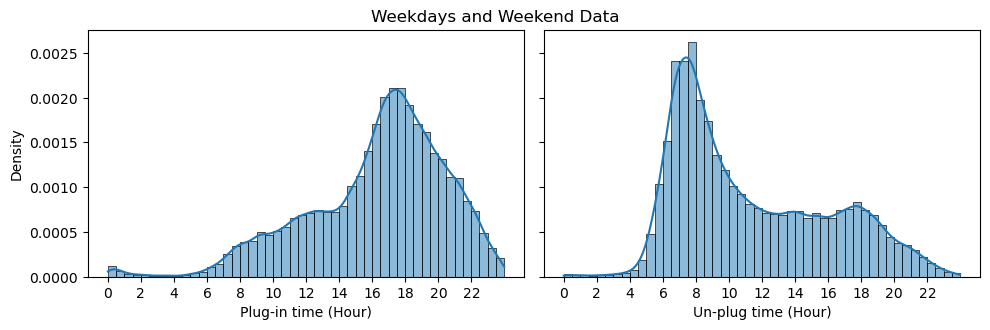

In [15]:
n_rows, n_cols=1,2
fig_size=(10,3.5)
# hist_def_kwargs['bins']=24
fig, axx = plt.subplots(n_rows, n_cols, figsize=fig_size, sharey=True, dpi=100)
plot_histo(Crowd_Green_df, fig, axx, 'Weekdays and Weekend Data' )

### Separate weekend and weekday 

In [16]:
sep_data = list(Crowd_Green_df.groupby('WeekdayOrWeekend'))
Weekday_df = sep_data[0][1]
Weekend_df = sep_data[1][1]

### Plot weekday data

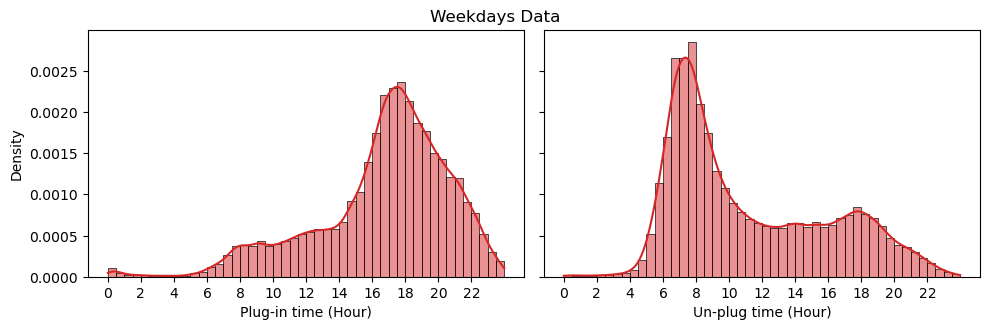

In [17]:
hist_def_kwargs['color'] = 'Tab:red'
fig, axx = plt.subplots(n_rows, n_cols, figsize=fig_size, sharey=True, dpi=100)
plot_histo(Weekday_df, fig, axx, 'Weekdays Data' )

### Plot Weekend data

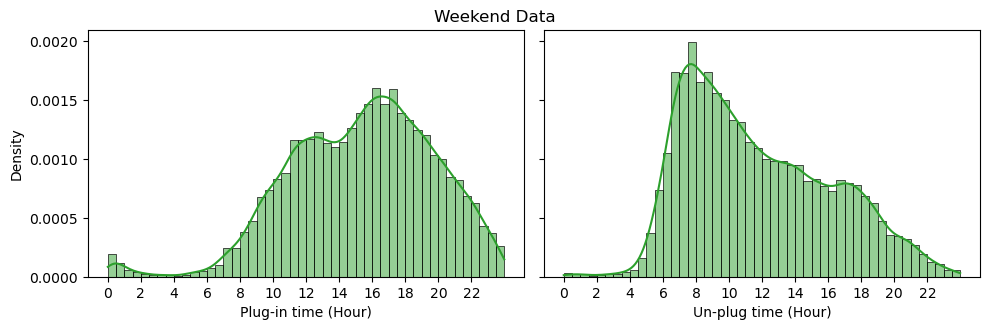

In [18]:
hist_def_kwargs['color'] = 'Tab:green'
fig, axx = plt.subplots(n_rows, n_cols, figsize=fig_size, sharey=True, dpi=100)
plot_histo(Weekend_df,fig, axx, 'Weekend Data' )

### Plot all the previous data in one figure

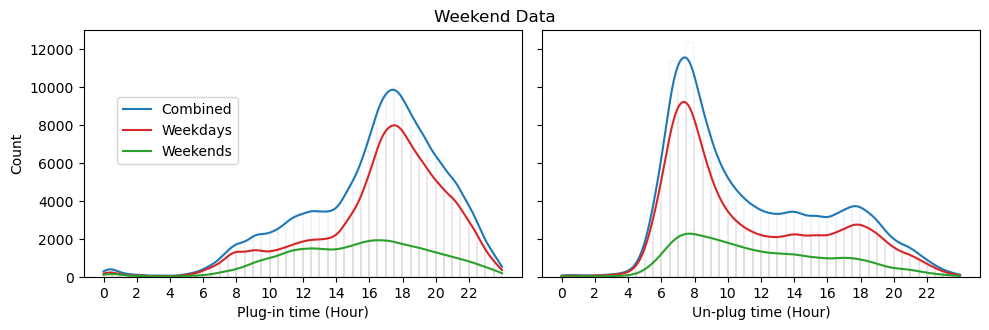

In [19]:
fig, axx = plt.subplots(n_rows, n_cols, figsize=fig_size, sharey=True, dpi=100)

hist_def_kwargs['fill']=False
hist_def_kwargs['lw']= 0.05
hist_def_kwargs['stat'] ='count'


hist_def_kwargs['color'] = 'Tab:blue'
plot_histo(Crowd_Green_df, fig, axx, )

hist_def_kwargs['color'] = 'Tab:red'
plot_histo(Weekday_df, fig, axx, )

hist_def_kwargs['color'] = 'Tab:green'
plot_histo(Weekend_df,fig, axx, 'Weekend Data' )

fig.legend(['Combined', 'Weekdays', 'Weekends'],bbox_to_anchor=(0.25,0.7))

<a id='weekdays'></a>
## Weekday

### Fit Distribution to plug-in and un-plug time

In [ ]:
res = list_fitdistribution(Weekday_df.StartTime_Minute, distribution_list)

In [21]:
res_stop_weekday = list_fitdistribution(Weekday_df.StopTime_Minute, distribution_list)

100%|##########| 47/47 [10:40<00:00, 13.63s/it] 


### Plot 5 closest fitted dstributions

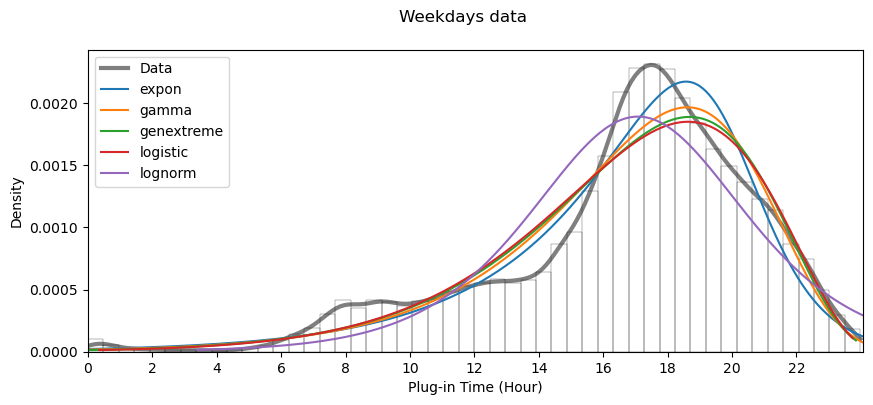

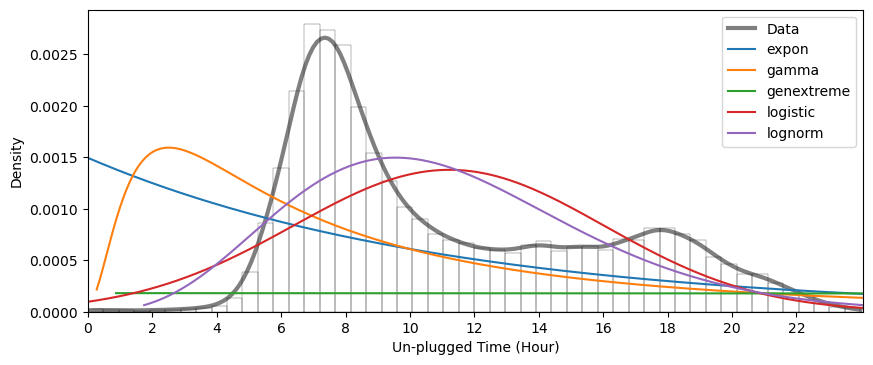

In [34]:
# Key words argument fot the histogram 
hist_def_kwargs["stat"] = 'density'
hist_def_kwargs["color"] = 'k'
hist_def_kwargs["lw"] = 0.2
kde_args= {'lw':3, 'alpha':0.5}


fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(Weekday_df.StartTime_Minute,line_kws=kde_args,  **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res),'Plug-in Time (Hour)',5)
fig.suptitle('Weekdays data')

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(Weekday_df.StopTime_Minute,line_kws=kde_args,  **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res_stop_weekday),'Un-plugged Time (Hour)',5)


<a id='weekends'></a>
## Weekends

### Fit Distribution to Weekeed plug-in and unplugged time

In [ ]:
res_start_weekend = list_fitdistribution(Weekend_df.StartTime_Minute, distribution_list)

In [24]:
res_stop_weekend = list_fitdistribution(Weekend_df.StopTime_Minute, distribution_list)

100%|##########| 47/47 [03:41<00:00,  4.71s/it]


### Plot 5 closest fitted distributions

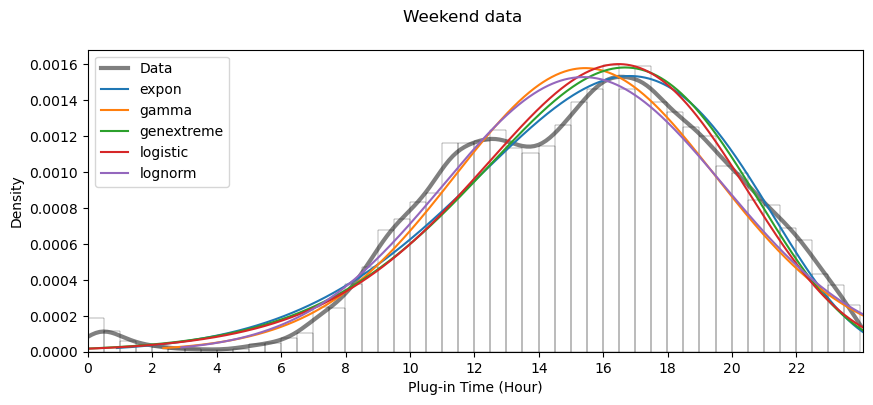

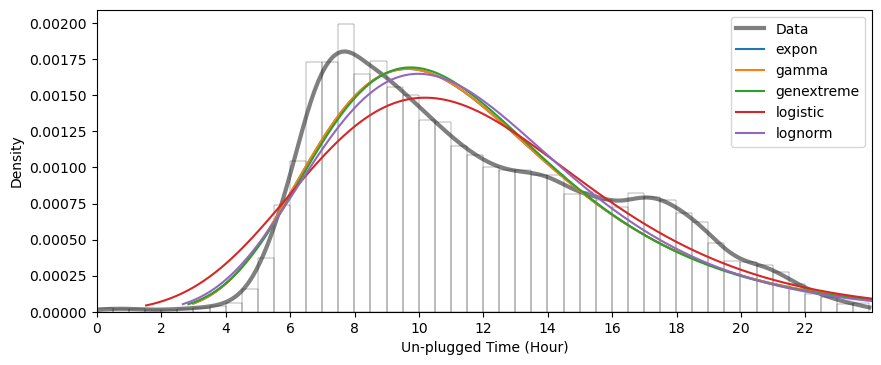

In [25]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(Weekend_df.StartTime_Minute,line_kws=kde_args,  **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res_start_weekend),'Plug-in Time (Hour)',5)
fig.suptitle('Weekend data')

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(Weekend_df.StopTime_Minute,line_kws=kde_args,  **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res_stop_weekend),'Un-plugged Time (Hour)',5)



<a id = 'consumed_energy'> </a>
## Consumed Energy

### Filtering

In [26]:
# Function that returns the logical and i.e. check if `value` is in [lower_bound, higher_bound] 
#                                                               ... lower_bound <= value <= higher_bound
binary_and = lambda lower_bound, value, higher_bound: (value >= lower_bound) & (value <= higher_bound)

# Extract the maximum capacity of the participants car
ev_max_kwh = Crowd_Green_df.ParticipantCarkWh.max()
ev_min_consumed = 1  # Set Minimum Energy 

# Set a filter : binary variable, based on the previous defined function
consumedKWh_filter = binary_and(ev_min_consumed, Crowd_Green_df.ConsumedkWh, ev_max_kwh)

### Plot distribution

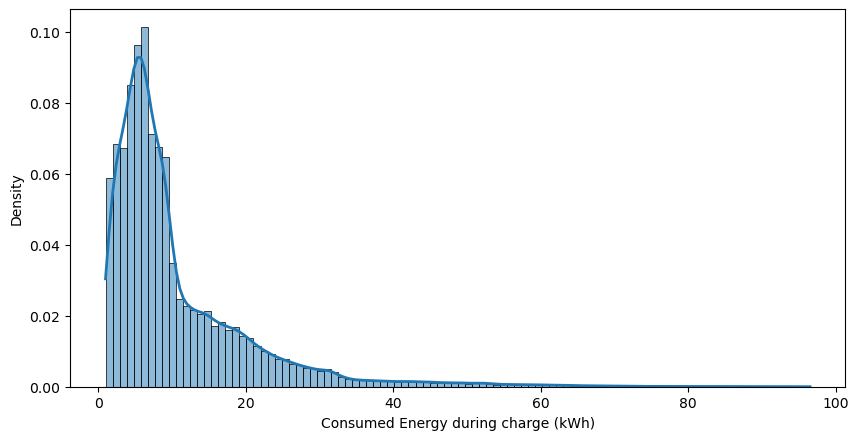

In [27]:
# Define histogram plot default keyword arguments
hist_def_kwargs = dict(stat ='density',
    bins= 100, 
    kde=True,
    color ='Tab:blue')

fig, axx = plt.subplots(1,1, figsize=(10,5), dpi = 100)
sbn.histplot(Crowd_Green_df.ConsumedkWh[consumedKWh_filter],line_kws={'lw':2, 'color':'blue',}, **hist_def_kwargs);
axx.set(xlabel='Consumed Energy during charge (kWh)');

### Fit and plot fitted distribution

In [ ]:
res_consumedkWh = list_fitdistribution(Crowd_Green_df.ConsumedkWh[consumedKWh_filter], distribution_list)

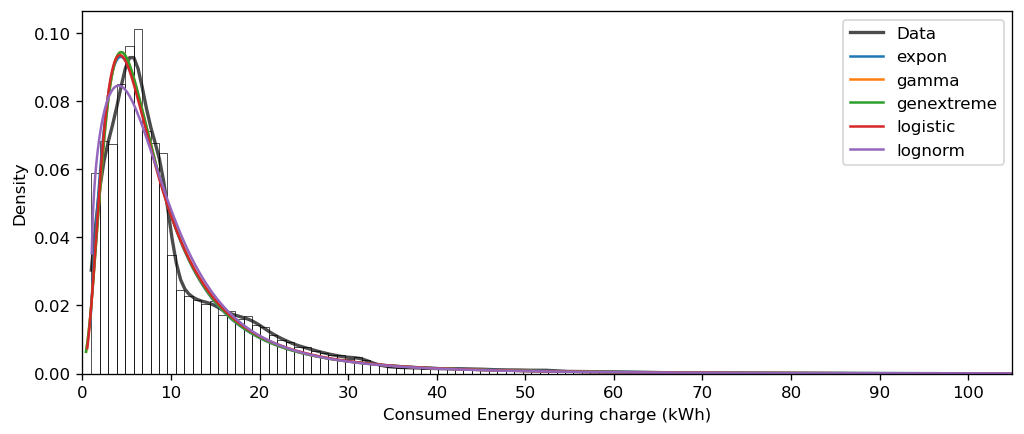

In [29]:
hist_def_kwargs["color"] = 'k'
hist_def_kwargs["lw"] = 0.4
hist_def_kwargs["kde"] = True
hist_def_kwargs["fill"] = False


kde_args= {'lw':2, 'alpha':0.7}

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=120)
sbn.histplot(Crowd_Green_df.ConsumedkWh[consumedKWh_filter],
             line_kws=kde_args,
             **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res_consumedkWh),'Consumed Energy during charge (kWh)',5)

axx.set(xlim=(0,105),
        xticks = np.arange(0,101,10), 
        xticklabels=range(0,101,10), ) ;

# # fig.suptitle('Weefdfsfs')

<a id = 'charging_duration'></a>
# Charging Duration

### Filtering

In [30]:
# extract all the rows with real values 
Crowd_Green_df_ChargingDuration = Crowd_Green_df.ChargingDuration[~Crowd_Green_df.ChargingDuration.isnull()]

# set the min and max charging duration to consider
chargingDuration_min = 5 # 1 day (minutes)
chargingDuration_max = 1440 # 1 day (minutes)

# set the filter 
chargingDuration_filter = binary_and(chargingDuration_min, Crowd_Green_df_ChargingDuration , chargingDuration_max)

### Plot distribution

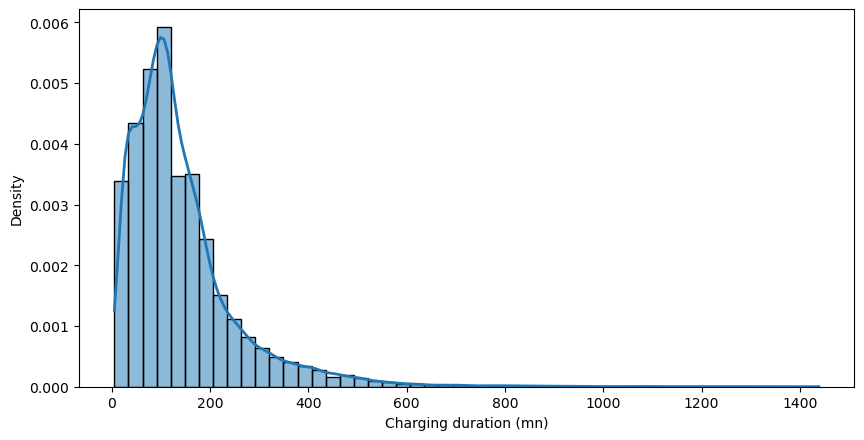

In [31]:
# Define histogram plot default keyword arguments
hist_def_kwargs = dict(stat ='density',
    bins= 50, 
    kde=True,
    color ='Tab:blue')

fig, axx = plt.subplots(1,1, figsize=(10,5), dpi = 100)
sbn.histplot(Crowd_Green_df_ChargingDuration[chargingDuration_filter] ,
             line_kws={'lw':2, 'color':'blue',},
             **hist_def_kwargs);
axx.set(xlabel='Charging duration (mn)');

### Fit and plot fitted distributions

In [32]:
res_chargingDuration = list_fitdistribution(Crowd_Green_df_ChargingDuration[chargingDuration_filter], distribution_list)

 98%|#########7| 46/47 [08:28<00:02,  2.01s/it] C:\Users\jprince\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|##########| 47/47 [08:30<00:00, 10.86s/it]


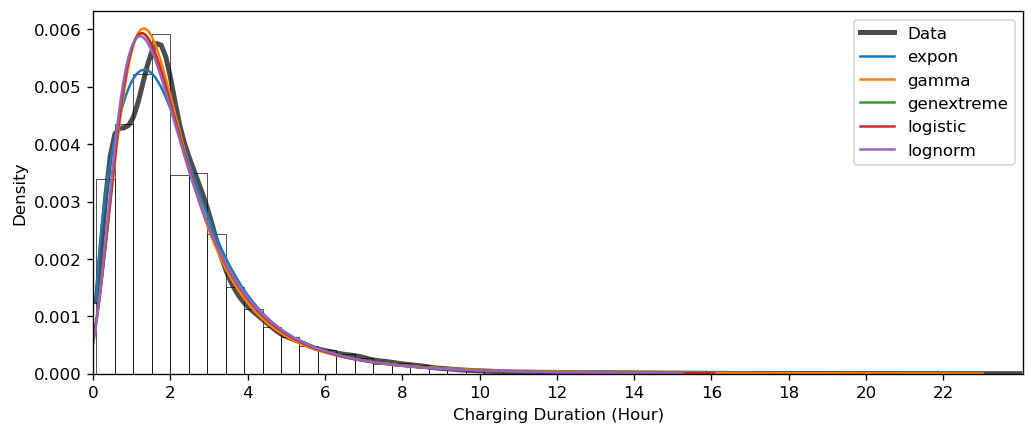

In [33]:
hist_def_kwargs["color"] = 'k'
hist_def_kwargs["lw"] = 0.4
hist_def_kwargs["kde"] = True
hist_def_kwargs["fill"] = False


kde_args= {'lw':3, 'alpha':0.7}

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=120)
sbn.histplot( Crowd_Green_df_ChargingDuration[chargingDuration_filter],
             line_kws=kde_args,
             **hist_def_kwargs)
plot_FittedDist(axx, ordered_dis_df(res_chargingDuration),'Charging Duration (Hour)',5)


***

<div class="alert alert-block alert-info">
<b>TODO:</b> Use Mixed of distribution to get a better fit for wrongly fitted data.
</div>